In [1]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append("../..")

In [4]:
import math

import geopandas as gpd
import numpy as np


In [5]:
import pandas as pd
import pystac_client
import stackstac

In [6]:
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling

In [7]:
from shapely import Point
from sklearn import decomposition, svm
from torchvision.transforms import v2

In [10]:
!pip install einops

In [11]:
!pip install vit_pytorch

In [12]:
from src.model import ClayMAEModule

In [27]:
# Point over Los Angeles, California
lat, lon = 38.655776, -121.106413  # Los Angeles city center

# Dates of interest (example dates for seasonal pool visibility)
start = "2023-06-01"
end = "2023-09-01"

In [28]:
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01),  # Bounding box to cover a wider area
    max_items=100,
    query={"eo:cloud_cover": {"lt": 20}},  # Lower cloud cover to increase image clarity
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

/Users/hana/anaconda3/envs/claymodel/lib/python3.11/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 15 items


In [35]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point of interest (in Los Angeles) into the image projection
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection for the point of interest
size = 128  # Reduced size in pixels to zoom in more closely
gsd = 3  # Reduced ground sampling distance (higher resolution in meters/pixel)
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

In [36]:
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-df77d6a7d03391d9ead135520f9a19d6' (time: 15,
                                                                band: 4,
                                                                y: 128, x: 128)> Size: 8MB
dask.array<fetch_raster_window, shape=(15, 4, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 120B 2023-...
    id                                       (time) <U24 1kB 'S2B_10SFH_20230...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 1kB 6.646e+05 ... 6....
  * y                                        (y) float64 1kB 4.28e+06 ... 4.2...
    constellation                            <U10 40B 'sentinel-2'
    ...                                       ...
    proj:shape                               object 8B {10980}
    title                          

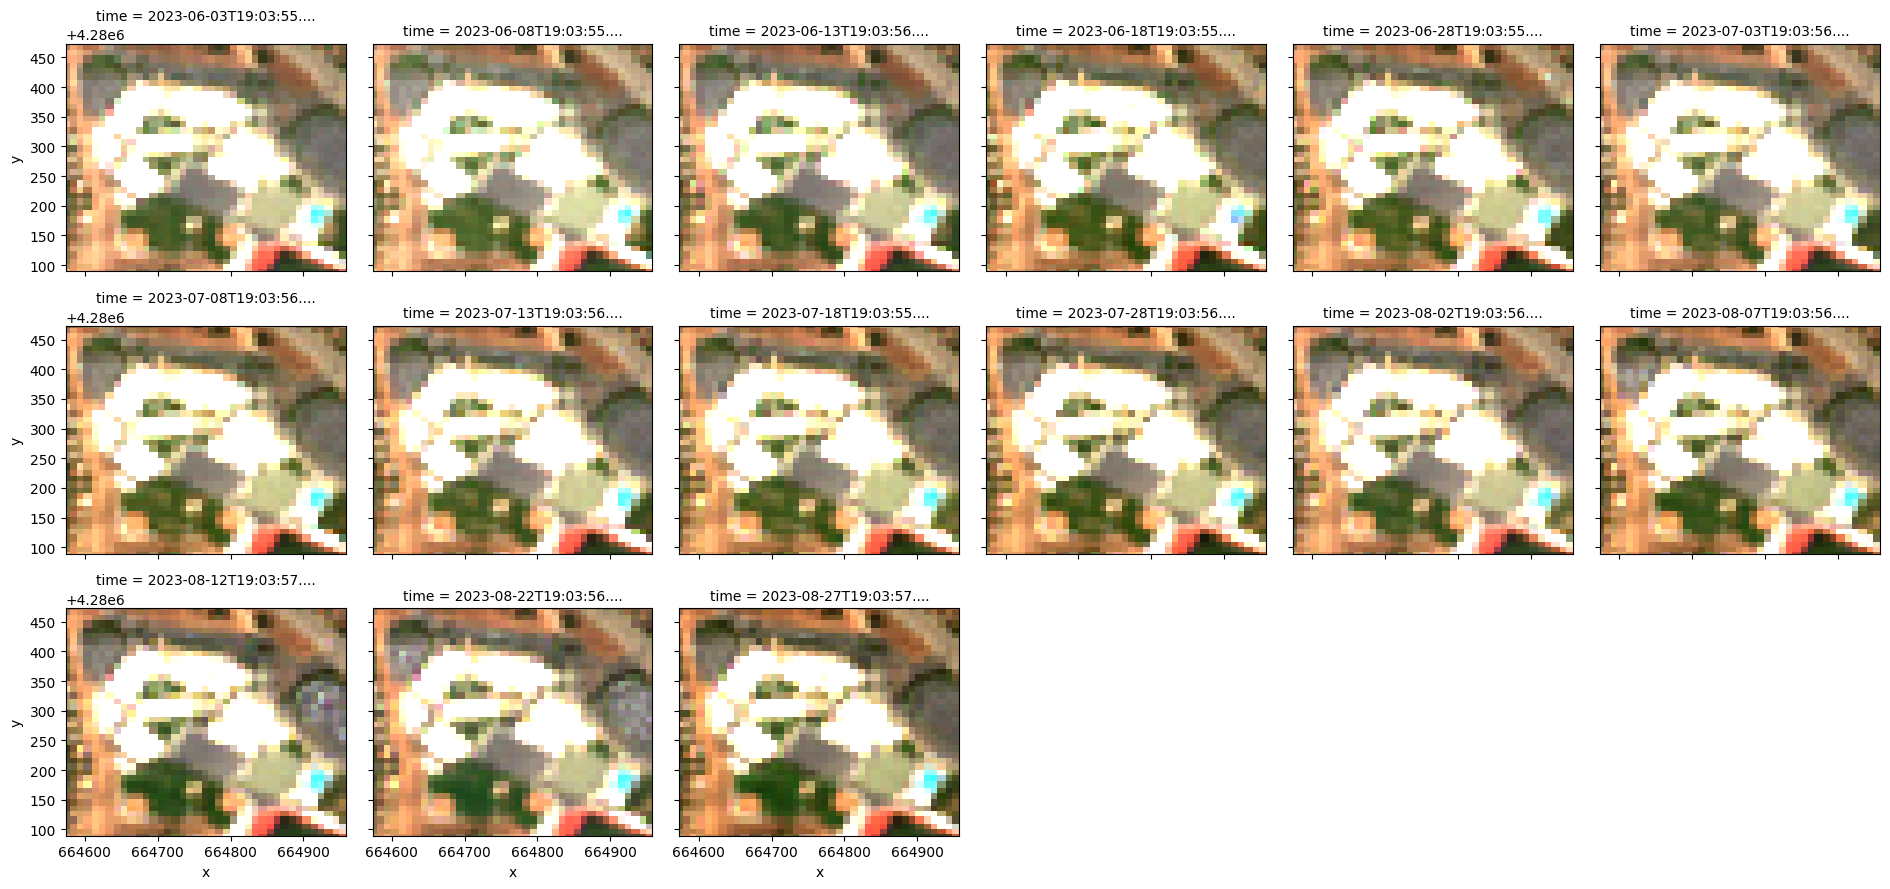

In [37]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

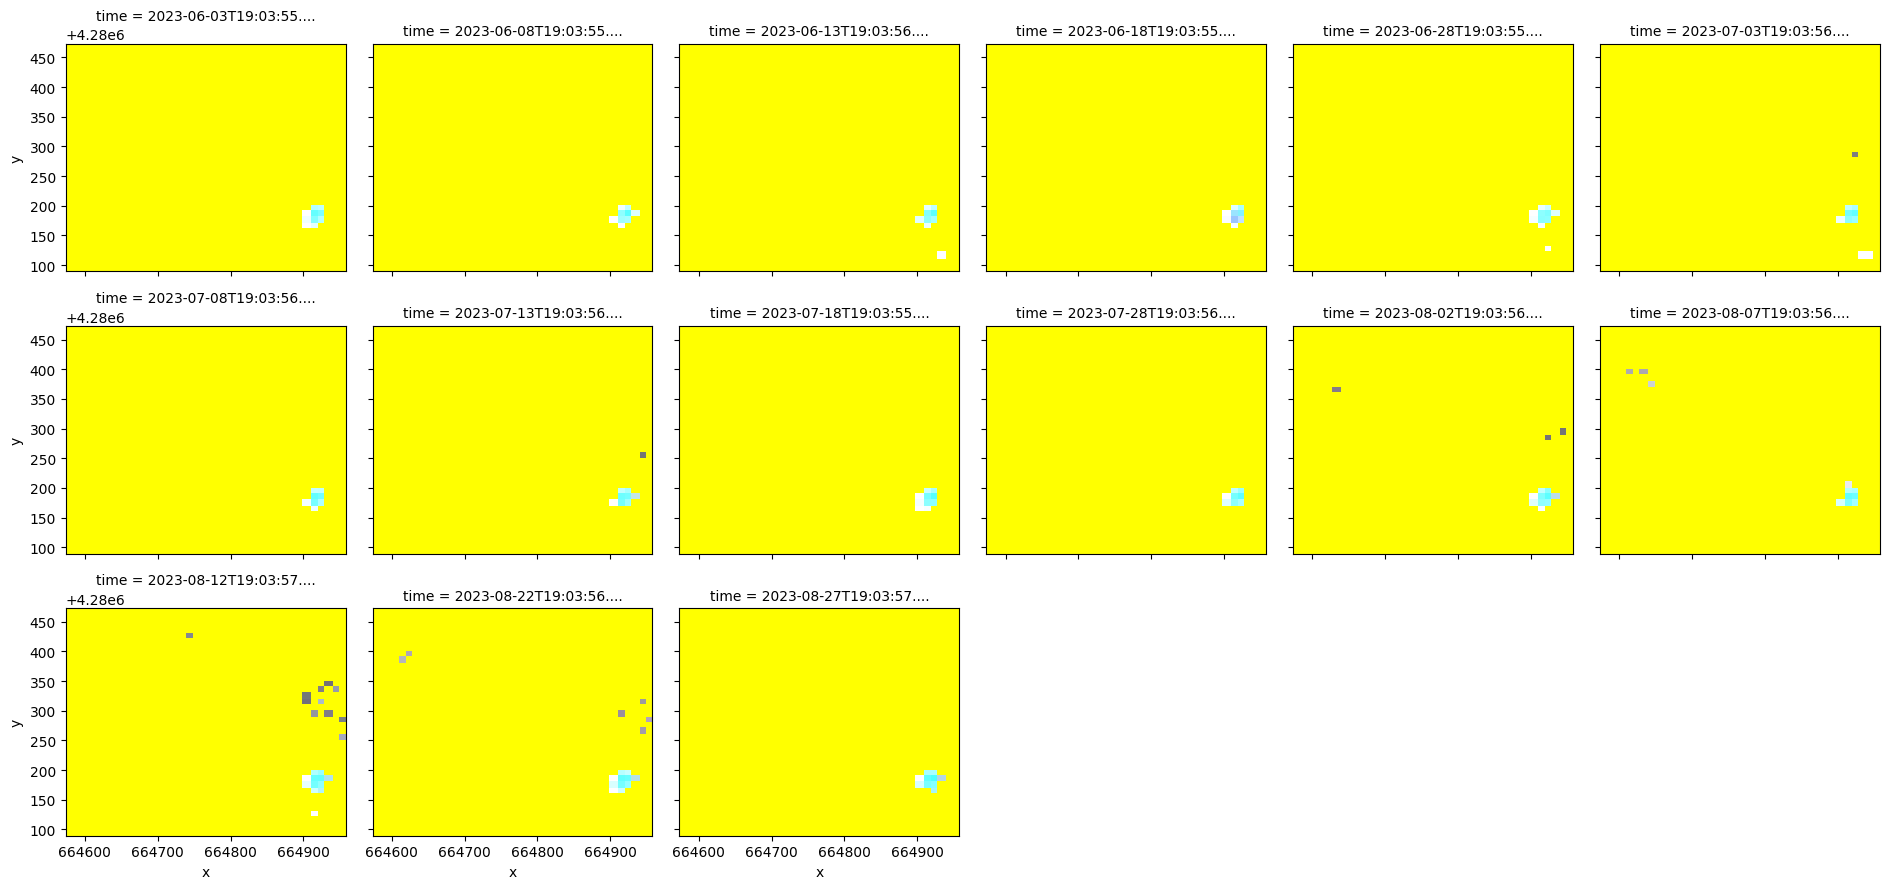

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

stack = stack.compute()

rgb_stack = stack.sel(band=["red", "green", "blue"])

rgb_array = rgb_stack.values 

highlighted_array = np.zeros_like(rgb_array)

for t in range(rgb_array.shape[0]):
    red, green, blue = rgb_array[t, 0, :, :], rgb_array[t, 1, :, :], rgb_array[t, 2, :, :]
    
    # Created a mask to identify blue areas
    blue_mask = (blue > red) & (blue > green)
    
    highlighted_image = np.stack([
        np.where(blue_mask, red, 2000),     
        np.where(blue_mask, green, 2000),    
        np.where(blue_mask, blue, 0)         
    ], axis=0)

    highlighted_array[t] = highlighted_image

highlighted_stack = xr.DataArray(
    highlighted_array,
    dims=("time", "band", "y", "x"),
    coords=rgb_stack.coords
)

highlighted_stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

plt.show()

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="./configs/metadata.yaml", shuffle=False, mask_ratio=0, map_location=device
)
model.eval()

model = model.to(device)

/Users/hana/anaconda3/envs/claymodel/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [20]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("./configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [21]:
print(type(stack.data))

<class 'numpy.ndarray'>


In [22]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [23]:
print(type(stack.data))

<class 'numpy.ndarray'>


In [24]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [25]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

IndexError: index 2 is out of bounds for axis 0 with size 2

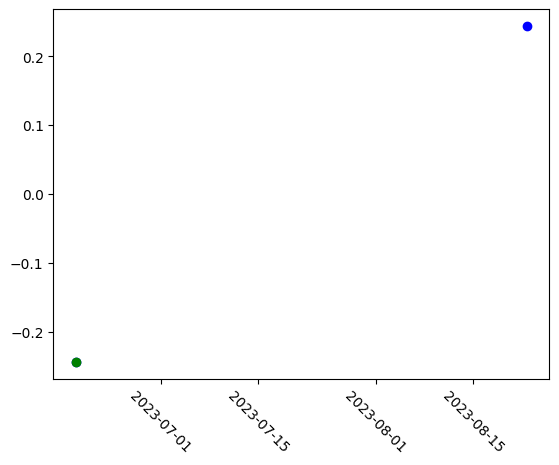

In [26]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

# Plot all points in blue first
plt.scatter(stack.time, pca_result, color="blue")

# Re-plot cloudy images in green
plt.scatter(stack.time[0], pca_result[0], color="green")
plt.scatter(stack.time[2], pca_result[2], color="green")

# Color all images after fire in red
plt.scatter(stack.time[-5:], pca_result[-5:], color="red")

In [ ]:
# Label the images we downloaded
# 0 = Cloud
# 1 = Forest
# 2 = Fire
labels = np.array([0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2])

# Split into fit and test manually, ensuring we have all 3 classes in both sets
fit = [0, 1, 3, 4, 7, 8, 9]
test = [2, 5, 6, 10, 11]

# Train a Support Vector Machine model
clf = svm.SVC()
clf.fit(embeddings[fit] + 100, labels[fit])

# Predict classes on test set
prediction = clf.predict(embeddings[test] + 100)

# Perfect match for SVM
match = np.sum(labels[test] == prediction)
print(f"Matched {match} out of {len(test)} correctly")

In [ ]:
print(type(stack.data))